# Summary:


1. Novel Perception defintion:
- from string to pytorch operation.

2. Related Work Measurment Definitions: using existing dataset.

# 1. Novel perception as tensor:

In [1]:
# Moved to atils.scripts.architectures.torch_nerf_src.network.NeRFS

import re
import torch
import torch.nn as nn

# Example encoder output size (can be adjusted based on your network's output dimension)
output_size = 10
encoder_outputs = torch.randn(output_size)  # Example tensor with 10 outputs

# The expression string
expression = "1 + 6 / (2 + 6)"

# Function to convert string expression to a reusable tensor operation
def expression_to_tensor_op(expression):
    '''
        tranforms id operations to torch tensor operation on vecotr with ids
        "1 / ( 1 + 4 )" -> tensor_operation {tensor -> tensor[1]/(tensor[1] + tensor[4])}
        Usage of returned operation: apply tensor_operation on encoder_outputs
        result = tensor_operation(encoder_outputs)
    '''
    # Replace each number in the expression with a tensor indexing operation
    expr_with_placeholders = re.sub(r'(\d+)', lambda x: f'encoder_outputs[{x.group(1)}]', expression)
    
    # Define a function that performs the operation when called
    def tensor_operation(encoder_outputs):
        # Safely evaluate the modified expression with encoder_outputs
        return eval(expr_with_placeholders, {"encoder_outputs": encoder_outputs})
    
    # Return the tensor operation as a callable function
    return tensor_operation



def category_to_index_expression(category_expression, category_names):
    """
    Transoform category expression string to logits index expression string.
    Example:
    "water / ( water + surface )" -> '1 / ( 1 + 4 )'
    """
    
    cat_exp_tokens = category_expression.split(" ")
    #Replace categories with indexes
    ind_exp_tokens = [str(category_names.index(s)) if s in category_names else s for s in cat_exp_tokens]
    
    index_expression = " ".join(ind_exp_tokens)
    
    return index_expression

##############################
##### Testing one formula #####

# Create the tensor operation
# tensor_operation = expression_to_tensor_op(expression)

# # Usage: apply tensor_operation on encoder_outputs
# result = tensor_operation(encoder_outputs)
# print("Result:", result)
# category_names = ['building', 'water', 'road', 'sidewalk', 'surface', 'tree', 'sky', "miscellaneous"]
# category_expression = "water / ( water + surface )"
# encoder_outputs = torch.arange(8) / 1

# encoder_outputs = torch.autograd.Variable(encoder_outputs, requires_grad=True) 
### #Create the index operation string
# index_expression    = category_to_index_expression(category_expression, category_names)

### # Create the tensor operation
# tensor_operation = expression_to_tensor_op(index_expression)

### # Usage: apply tensor_operation on encoder_outputs
# result = tensor_operation(encoder_outputs)
# print("\nInput:", dict(zip(category_names, encoder_outputs)))
# print("\nResult:", {category_expression : result})



Result: tensor(-5.3909)


In [2]:
'''Moved from Urban Perception Metrics Analysis.ipynb to test_location_encoder.py - March 17th 2025'''
def formula_and_dict_to_perception(formula_expression, f_xyz_semantics_dict):
    """
        Parse perception string formulas to value.
        Replace each semantic string in the formula_expression with it's value in f_xyz_semantics_dict
        Return the value of the evaluated formula.
    """
    form_literals = formula_expression.split(" ")
    for i in range(len(form_literals)):
        literal = form_literals[i] #on of the sematics
        if literal in f_xyz_semantics_dict:
            form_literals[i] = str(f_xyz_semantics_dict[literal])
    
    numerical_formula = " ".join(form_literals)
    try:
        index_value = eval(numerical_formula)
    except:#Division by 0
        index_value = 0
    return index_value #eval(numerical_formula)
    #print("Semantics: ", f_xyz_semantics_dict)
    #print("Semantics formula: ", formula_expression)
    #print("Numerical formula: ", numerical_formula)
    #print("Evaluated formula: ", eval(numerical_formula))
    
    
import pandas as pd
perc_def = pd.read_json('./utils/assets/data/perception_metrics/predefinedPerceptions.json')
predefined_formulas_dict = {p: perc_def[p].values[0]["expression"] for p in perc_def}
test_as_query_df = pd.read_json("./utils/assets/data/semantics/test_set_as_query.json")
from utils.test_location_encoder import formula_and_dict_to_perception
formula_and_dict_to_perception(formula_expression=predefined_formulas_dict["enclosure"]\
                               , f_xyz_semantics_dict = test_as_query_df["f_xyz"].values[0])


0.9955867116

In [ ]:
def encoder_outputs_to_indexes(self, encoder_output: torch.Tensor):
    '''
    Apply index formulas to encoder_output
    '''
    
    results = []
    for ce in this.category_expressions:
        #Create the index operation string
        index_expression = category_to_index_expression(ce, this.category_names)
        # Create the tensor operation
        tensor_operation = expression_to_tensor_op(index_expression)

        # Usage: apply tensor_operation on encoder_outputs
        result = tensor_operation(encoder_outputs)
        results.append(result)
    
    return torch.vstack(results)

## Testing end to end input angles to prediction to gradient propagation.

In [8]:
from utils.scripts.architectures.torch_nerf_src import network
import pandas as pd

info_dict_path       = "./utils/assets/data/full_semantics/models/training_info_1000.json"
trained_model_path   = "./utils/assets/data/full_semantics/models/encoder_1000.pt"
data_path            = "./utils/assets/data/full_semantics/test_set_4800.json"

test_df = pd.read_json(data_path)

# Initialize NeRFS model with weights of trainedNeRF model
info_dict       = pd.read_json(info_dict_path).to_dict()[0]
# return info_dict
norm_params     = (torch.tensor(info_dict["xyz_centroid"]), torch.tensor(info_dict["xyz_max-min"]), torch.tensor(info_dict["xyzh_centroid"]), torch.tensor(info_dict["xyzh_max-min"]))


trained_encoder            = network.nerfs.NeRFS(norm_params=norm_params, surface_type="square", pos_dim=info_dict["enc_input_size"], output_dim=info_dict["num_present_classes"],  view_dir_dim=info_dict["enc_input_size"])
trained_encoder.load_state_dict(torch.load(trained_model_path))

xyz  = torch.autograd.Variable(torch.tensor(test_df.values[:,:6][0].astype(float)[:3]), requires_grad=True)
xyzh = torch.autograd.Variable(torch.tensor(test_df.values[:,:6][0].astype(float)[3:]), requires_grad=True)

#Needs nerfs to be initalized with p, c and r parameters.
# input_a, input_b = torch.autograd.Variable(torch.tensor([.5]), requires_grad=True), torch.autograd.Variable(torch.tensor([.5]), requires_grad=True)


_, latent_features, prediction = trained_encoder.predict_from_raw(xyz, xyzh, return_latent_features=True)


category_names = ['building', 'water', 'road', 'sidewalk', 'surface', 'tree', 'sky', "miscellaneous"]
category_expressions = ["water / ( water + surface )", 
                        "building",
                        "tree / ( tree + road )"]


encoder_outputs = prediction[0]
print("\nInput:", dict(zip(category_names, (encoder_outputs.detach().numpy()+1)/2)))

results = []
for ce in category_expressions:
    #Create the index operation string
    index_expression    = category_to_index_expression(ce, category_names)
    # Create the tensor operation
    tensor_operation = expression_to_tensor_op(index_expression)

    # Usage: apply tensor_operation on encoder_outputs
    result = tensor_operation(encoder_outputs)
    results.append(result)

    print("\nResult:", {ce : result.detach().numpy()})
    result.backward(retain_graph=True)
    print("Gradients:")
    print("\txyz: ", xyz.grad)
    print("\txyzh: ", xyzh.grad)


torch.vstack(results).mean().backward(retain_graph=True)

print("\nMean Gradients:")
print("\txyz: ", xyz.grad)
print("\txyzh: ", xyzh.grad)

print("\nFull Output of custom formulas:\n", torch.vstack(results))



Surface not initialized properly. Can only predict from raw position and direction.

Input: {'building': 0.46274295, 'water': 8.225441e-06, 'road': 0.004007727, 'sidewalk': 0.0026765764, 'surface': 0.00989157, 'tree': 0.013746381, 'sky': 0.5069622}

Result: {'water / ( water + surface )': array(0.50499105, dtype=float32)}
Gradients:
	xyz:  tensor([-6.2079e-06,  1.9403e-04, -1.3833e-04], dtype=torch.float64)
	xyzh:  tensor([-0.0001, -0.0014,  0.0003], dtype=torch.float64)

Result: {'building': array(-0.07451408, dtype=float32)}
Gradients:
	xyz:  tensor([-8.9609e-05, -7.9803e-03,  1.5807e-03], dtype=torch.float64)
	xyzh:  tensor([ 0.0084, -0.0153,  0.0264], dtype=torch.float64)

Result: {'tree / ( tree + road )': array(0.49504265, dtype=float32)}
Gradients:
	xyz:  tensor([-0.0001, -0.0080,  0.0016], dtype=torch.float64)
	xyzh:  tensor([ 0.0079, -0.0152,  0.0269], dtype=torch.float64)

Mean Gradients:
	xyz:  tensor([-0.0002, -0.0106,  0.0022], dtype=torch.float64)
	xyzh:  tensor([ 0.0106,

# 2. Measurements definition


Measurements defined in:

Measuring human perceptions of streetscapes to better inform urban renewal: A perspective of scene semantic parsing


https://www.sciencedirect.com/science/article/pii/S0264275120314347?ref=pdf_download&fr=RR-2&rr=8c5b7ead683160a5

In [1]:
import numpy as np
import pandas as pd

# category_names = ['building', ' water', 'tree', 'sky']
#[' building' ' water' ' road ' ' sidewalk' ' surface' ' tree' ' sky', "miscellaneous"]
train_df = pd.read_json("./utils/assets/data/splits_physical/train_set_100-percent.json")
semantics_pixels     = np.vstack(train_df["f_xyz_raw"].values)
semantic_percentages = semantics_pixels / semantics_pixels.sum(axis=1)[:, np.newaxis]


test_df         = pd.read_json("./utils/assets/data/splits_physical/test_set_4800.json")
test_pixels     = np.vstack(test_df["f_xyz_raw"].values)
test_semantic_percentages = test_pixels / test_pixels.sum(axis=1)[:, np.newaxis]


semantics_pixels.sum(axis=1).min(), semantics_pixels.sum(axis=1).max(), \
semantic_percentages.sum(axis=1).min(), semantic_percentages.sum(axis=1).max(), semantic_percentages.shape


(1048576, 1048576, 1.0, 1.0, (21432, 8))

__Greeness__ - trees percentage

__Openness__ - sky percentage

__Imageability__ - buildings + street signs or street furniture or miscellaneous

Bn denotes the proportion of building pixels, Tn denotes the proportion of tree pixels, Rn denotes the proportion of road pixels, p1n denotes the proportion of pavement pixels, and Fn denotes the proportion of fence pixels. The equation denotes the extent to which street canyons are visually enclosed by a street wall and corresponding horizontal elements.


__Encolusre__ - buildings + trees / road or road-like + pavement or sidewalk + fences

P1n denotes the proportion of pavement pixels, Fn denotes the proportion of fence pixels, and Rn denotes the proportion of road pixels. The equation denotes the visual impact of the perceptible road conditions on the walking experience.

__Walkability__ - pavement or sidewalk + fences / road

Bn denotes the proportion of building pixels, and Sn denotes the proportion of sign symbol pixels. The equation denotes the impression of the street in terms of richness and diversity shaped by buildings, sign symbols and other street furniture.

# Conclusion of metrics in our own classes

[0:' building' 1:' water' 2:' road ' 3:' sidewalk' 4:' surface' 5:' tree' 6:' sky', 7:"miscellaneous"]

__Greeness__ - trees 

__Openness__ - sky 

__Imageability__ - buildings  + miscellaneous

__Enclosure__ - (buildings  + trees)  / (road + surface + sidewalk + miscellaneous + buildings  + trees) (+ buildings  + trees added in order to have a maxiumum of 1)

__Walkability__ - sidewalk / (road + sidewalk) (we added sidewalk here because we are interested in  percentage of sidewalks out of the total road + sidewalk / a maxium of 1)

additional:
__Serenity__ Water + Sky (or just water)

__Depth Score__ - 1 - 100 based on depth histogram mode. 

In [2]:
sp                 = semantic_percentages 

perception_metrics = ["greenness", "openness", "imageability", "encolusre", "walkability", "serenity"]

train_df["greenness"]     = sp[:,5] # trees
train_df["openness"]     = sp[:,6] # sky
train_df["imageability"] = sp[:,0] + sp[:,7] #buildings + misc

#eclosure:
enc_num = (sp[:,0] + sp[:,5])
enc_den = (sp[:,2] + sp[:,3] + sp[:,4] + sp[:,7] + sp[:,0] + sp[:,5])
train_df["encolusre"]    = np.divide(enc_num, enc_den, out=np.zeros_like(enc_num), where=enc_den!=0)
# train_df["encolusre"]    = (sp[:,0] + sp[:,5]) / (sp[:,2] + sp[:,3] + sp[:,4] + sp[:,7] + sp[:,0] + sp[:,5])

#walkability:
walk_num = (sp[:,4])
walk_den = (sp[:,2] + sp[:,4])
train_df["walkability"]    = np.divide(walk_num, walk_den, out=np.zeros_like(walk_num), where=walk_den!=0)
# train_df["walkability"]  = (sp[:,4] ) / (sp[:,2] + sp[:,4]) # sidewalk / road + sidewalk 


train_df["serenity"]     = sp[:,2] + sp[:,6] #water + sky


train_df["f_xyz_perception"] = train_df[perception_metrics].values.tolist()

pd.DataFrame(perception_metrics, columns=["class"])\
.to_csv("./utils/assets/data/perception_metrics/classes_index.csv", index_label="color")

train_df.to_csv("./utils/assets/data/perception_metrics/train_set_100-percent.csv", index=False)
train_df.to_json("./utils/assets/data/perception_metrics/train_set_100-percent.json", indent=4, orient="records")

# train_df.head()

In [2]:
sp                 = test_semantic_percentages 

perception_metrics = ["greenness", "openness", "imageability", "encolusre", "walkability", "serenity"]

test_df["greenness"]     = sp[:,5] # trees
test_df["openness"]     = sp[:,6] # sky
test_df["imageability"] = sp[:,0] + sp[:,7] #buildings + misc

#eclosure:
enc_num = (sp[:,0] + sp[:,5])
enc_den = (sp[:,2] + sp[:,3] + sp[:,4] + sp[:,7] + sp[:,0] + sp[:,5])
test_df["encolusre"]    = np.divide(enc_num, enc_den, out=np.zeros_like(enc_num), where=enc_den!=0)
# test_df["encolusre"]    = (sp[:,0] + sp[:,5]) / (sp[:,2] + sp[:,3] + sp[:,4] + sp[:,7] + sp[:,0] + sp[:,5])

#walkability:
walk_num = (sp[:,4])
walk_den = (sp[:,2] + sp[:,4])
test_df["walkability"]    = np.divide(walk_num, walk_den, out=np.zeros_like(walk_num), where=walk_den!=0)
# test_df["walkability"]  = (sp[:,4] ) / (sp[:,2] + sp[:,4]) # sidewalk / road + sidewalk 


test_df["serenity"]     = sp[:,2] + sp[:,6] #water + sky


test_df["f_xyz_perception"] = test_df[perception_metrics].values.tolist()

# pd.DataFrame(perception_metrics, columns=["class"])\
# .to_csv("./utils/assets/data/perception_metrics/classes_index.csv", index_label="color")

test_df.to_csv("./utils/assets/data/perception_metrics/test_set_4800.csv", index=False)
test_df.to_json("./utils/assets/data/perception_metrics/test_set_4800.json", indent=4, orient="records")

# test_df.head()

# Train encoder on Perception metrics

In [4]:

from utils.scripts.architectures.train_location_encoder import train_model_on_data


file_store = "./utils/assets/data/perception_metrics/train_set_100-percent.json"
ne = 350
model_name = f"encoder_{ne}.pt"

# Train NeRF for ne epochs
encoder_net, tr_losses_history, test_losses_history, vdf \
    = train_model_on_data(data_path=file_store, num_epochs=ne, model_name=model_name, label_name="f_xyz_perception")


Selected label indexes: [0 1 2 3 4 5] [ True  True  True  True  True  True]
Train model based on selected label indexes: ['greeness' 'openness' 'imageability' 'encolusre' 'walkability' 'serenity']
Training data percentace 100.00% - 17,145 samples, for 350 epochs:


Epoch 350 / 350- Training loss 0.07542 - test loss 0.09254: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 350/350 [10:09<00:00,  1.74s/it]

Model weights saved at:
	./utils/assets/data/perception_metrics/models/encoder_350.pt

Training for 
	350     epochs took: 
	609s, for an average of: 
	1.7s per epoch.


In [82]:
np.ones_like([2,3]).astype(bool)

array([ True,  True])

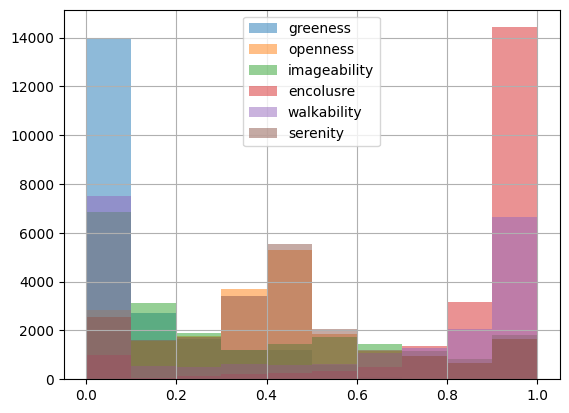

In [72]:
import matplotlib.pyplot as plt

for pm in perception_metrics:#[::-1]:
    train_df[pm].hist(label=pm, alpha=.5)#, color=pm[0])#sort_values()
#     break
# train_df["walkability"].hist(label="w", alpha=.5)
plt.legend()